# Evaluation of multi-omics GRN inference methods
## Preprocessing multi-omics data
### by Jalil Nourisa

# Imports 

In [56]:
import os
import gzip
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix


import scanpy as sc
import matplotlib.pyplot as plt
import tqdm
import scipy
import seaborn as sns
import json
import anndata as ad
import warnings
# import decoupler as dc

# from venn import venn 

import matplotlib
matplotlib.rc('font', family='serif')
matplotlib.rc('text', usetex='false')
matplotlib.rcParams.update({'font.size': 10})

import sys
sys.path.append('../../')
from grn_benchmark.src.helper import colors_blind, plot_umap

input_dir = '../../task_grn_inference/resources/inference_data/'
work_dir = '../output'
results_folder = f'../../task_grn_inference/resources/results'

T_cells = ['T regulatory cells', 'T cells CD8+', 'T cells CD4+']
def func_leiden(adata):
    adata.layers['counts'] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    sc.tl.pca(adata, n_comps=50, use_highly_variable=True)
    sc.pp.neighbors(adata, n_pcs=30)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)

# scRNA-seq
We use provided normalized values as X and store the counts in the layers.

## QS

In [29]:
multiomics_rna = ad.read(f'{input_dir}/op_rna.h5ad')
multiomics_rna

AnnData object with n_obs × n_vars = 25551 × 22787
    obs: 'cell_type', 'donor_id'
    var: 'gene_ids', 'interval'

In [4]:
import sctk
sctk.calculate_qc(multiomics_rna, flags={"mito": r"^MT-", "ribo": r"^RP[LS]"})
# sctk.calculate_qc(multiomics_rna)
sctk.cellwise_qc(multiomics_rna)

/root/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


n_counts: [1000.0000463230983, 19978.994140625], 25547/25547 passed
n_genes: [691.1768837674327, 5745.001953125], 25429/25547 passed
percent_mito: [0.0, 15.571746011893392], 25402/25547 passed
percent_ribo: [0.8829415259221228, 16.21716400235061], 25201/25547 passed
25034/25547 pass


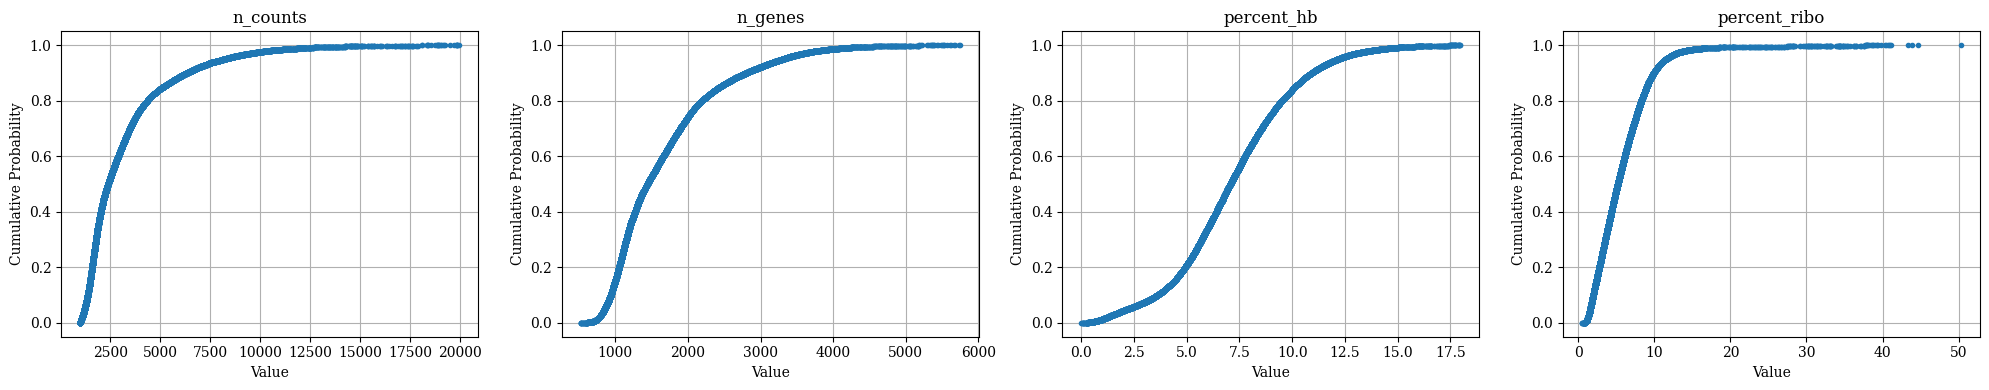

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(20,4))
def plot_CDF(data, title, ax):
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    ax.plot(x, y, marker='.', linestyle='none')
    ax.set_xlabel('Value')
    ax.set_ylabel('Cumulative Probability')
    ax.set_title(title)
    ax.grid(True)

plot_CDF(multiomics_rna.obs.n_counts, 'n_counts', axes[0])
plot_CDF(multiomics_rna.obs.n_genes, 'n_genes', axes[1])
plot_CDF(multiomics_rna.obs.percent_mito, 'percent_hb', axes[2])
plot_CDF(multiomics_rna.obs.percent_ribo, 'percent_ribo', axes[3])
plt.tight_layout()
plt.show()

## UMAP

In [5]:
rna = ad.read(f'{input_dir}/op_rna.h5ad')
atac = ad.read(f'{input_dir}/op_atac.h5ad')


/Users/jno24/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/Users/jno24/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [28]:
atac.X.data

array([2., 4., 4., ..., 2., 2., 1.], dtype=float32)

In [29]:
sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor='seurat_v3', layer='X_norm')
sc.pp.pca(rna, use_highly_variable=True)
sc.pp.neighbors(rna)
sc.tl.umap(rna)

/Users/jno24/miniconda3/envs/py10/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/Users/jno24/miniconda3/envs/py10/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


In [31]:
X_norm = sc.pp.normalize_total(atac, inplace=False)['X']
atac.layers['X_norm'] = sc.pp.log1p(X_norm, copy=True)

# sc.pp.highly_variable_genes(atac, n_top_genes=2000, flavor='seurat_v3', layer='X_norm')
sc.pp.pca(atac, use_highly_variable=False, layer='X_norm')
sc.pp.neighbors(atac)
sc.tl.umap(atac)

/Users/jno24/miniconda3/envs/py10/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


In [37]:
multiomics_rna_hvg.obs.donor_id = multiomics_rna_hvg.obs.donor_id.map({'donor_0': 'Donor 1', 'donor_1': 'Donor 2', 'donor_2': 'Donor 3'})

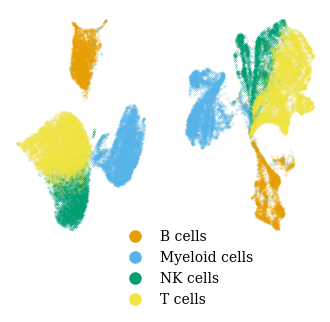

In [57]:
figsize = (4, 3)
fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=False)
bbox_to_anchor = (-.7, 1)
s = .02
ax = axes[0]
plot_umap(rna, color='cell_type', palette=colors_blind, ax=ax, 
                bbox_to_anchor=bbox_to_anchor, s=s)
ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.get_legend().remove()

ax = axes[1]
plot_umap(atac, color='cell_type', palette=colors_blind, ax=ax, 
                bbox_to_anchor=bbox_to_anchor, s=s)
ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
legend = ax.get_legend()
legend.get_title().set_fontweight('bold')  # Make the legend title bold
legend.set_bbox_to_anchor((-0.5, 0.1))
fig.savefig(f"{results_folder}/figs/umap.png", dpi=300, transparent=True, bbox_inches='tight')

# scATAC-seq

## Formatize the data

## UMAP plot using scATAC-seq


In [4]:
adata_atac = ad.read_h5ad(f'{input_dir}/multiomics_atac.h5ad')

In [5]:
adata_atac.layers['counts'] = adata_atac.X.copy()

In [6]:
# import warnings
warnings.simplefilter("ignore")
with warnings.catch_warnings():
    sc.pp.normalize_total(adata_atac)
    sc.pp.log1p(adata_atac)
    sc.pp.highly_variable_genes(adata_atac, n_top_genes=2000)
    sc.tl.pca(adata_atac, svd_solver='arpack', use_highly_variable=True)
    sc.pp.neighbors(adata_atac, n_neighbors=10, n_pcs=50)
    sc.tl.umap(adata_atac)
adata_atac

AnnData object with n_obs × n_vars = 25551 × 135418
    obs: 'cell_type', 'donor_id'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

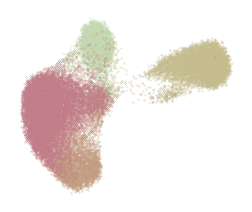

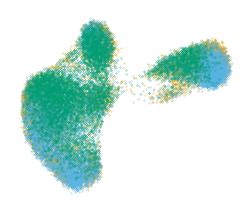

In [42]:
from local_utils import plots 
figsize = (3, 2.5)
fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=False)
bbox_to_anchor = (-.5, 1)
s = .05
plots.plot_umap(adata_atac, color='cell_type', palette=plots.colors_cell_type, ax=ax, 
                bbox_to_anchor=bbox_to_anchor, s=s, legend=False)
ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')

fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=False)
plots.plot_umap(adata_atac, color='donor_id', palette=plots.colors_blind, 
                ax=ax, bbox_to_anchor=bbox_to_anchor, s=s, legend=False)
ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')

fig.savefig(f'{work_dir}/preprocess/figs/umap_atac.png', dpi=300, transparent=True)